In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from hypso1 import Hypso1
from PIL import Image
from sklearn.decomposition import PCA
from read_bip import read_bip

# PCA feature seleciton

Notes: 
- We can explain 95% of the variance with only 3 PC components
- It seems like the curve for explained variance from the different bands is quite logarithmic, so it does not seem that we can drop a lot of bands very easily
- Contains plots of which bands the first PCs use, plots of which bands that are most important based on the method, and vectors that order the bands based on which that are most important according to the method

In [ ]:
l1a_nc_file = "data/h1_florida_2022-12-10T15-08-56Z/florida_2022-12-10T15-08-56Z-l1a.nc"
capture_path = "data/h1_florida_2022-12-10T15-08-56Z"
label_path = "data/labled_data/florida_2022-12-10_class_NPY_FORMAT.npy"

## read bip

data/h1_florida_2022-12-10T15-08-56Z/z_compressed_cube.bip
(78468480,)


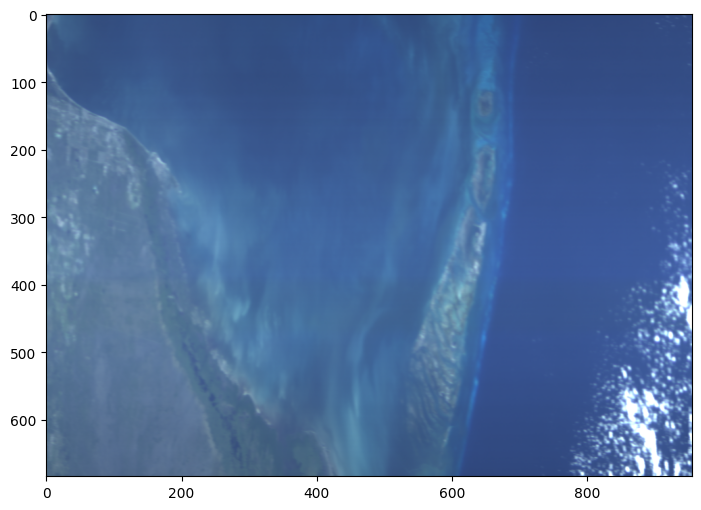

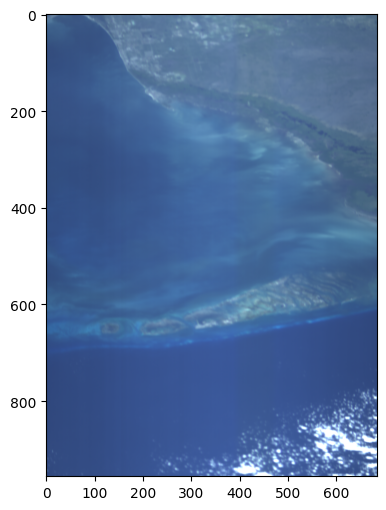

In [4]:

rgb, hsi =  read_bip(capture_path, scaling=1)

plt.figure(figsize=(15,6))
plt.imshow(rgb)
# plt.axis("off")
plt.figure(figsize=(15,6))
composite = hsi[:,:,(59, 70, 89)].astype('float32')
# composite = composite.transpose((1,0,2))
composite_8bit = (255*composite/composite.max())
hsi_image = Image.fromarray(composite_8bit.astype('uint8'))
plt.imshow(hsi_image)
# plt.axis("off")

## Make l1b

In [5]:
satobj = Hypso1(path=l1a_nc_file, verbose=True)

[INFO] Loading L1a capture florida_2022-12-10T15-08-56Z
[INFO] Capture spatial dimensions: (956, 684)
[INFO] Capture capture type: nominal
[INFO] No georeferencing .points file provided. Skipping georeferencing.


In [6]:
satobj.generate_l1b_cube()

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...


In [7]:
l1b_cube = np.array(satobj.get_l1b_cube())

In [8]:
satobj.generate_geometry()

[INFO] Running geometry computation...
ECI position samples: 1634
Quaternion samples: 1634
ADCS time range: 1670684280.000000 to 1670685160.250000
Frame time range: 1670684936.677999 to 1670684980.087090
174 sample(s) inside frame time range
Interpolating 956 frames
Spatial dimensions: 956 frames/lines, 684 pixels/samples
Computing pixel latitude and longitude coordinates...
Interpolating pixel coordinate gaps...
Using geometry-computed latitude and longitude values
Computing local angles (sun and satellite azimuth and zenith angles)...
Image Center (lat,lon): (25.17304	-81.72148)
Image Center elevation angle: 56.03251
Image Center off-nadir angle: 49.88698


In [9]:
satobj.generate_toa_reflectance()

toa_rrs_cube = np.array(satobj.get_toa_reflectance())

## read lables

(956, 684)


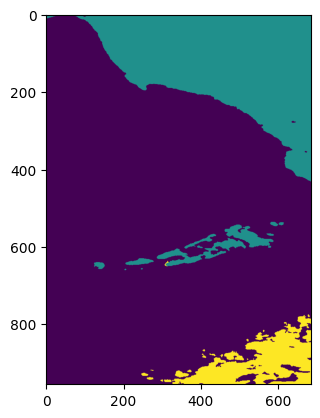

In [10]:
florida_labled = np.load(file=label_path)

# 0 = sea
# 1 = land
# 2 = cloud

print(florida_labled.shape)
plt.imshow(florida_labled)

## Do PCA

### Perform PCA on part of the capture

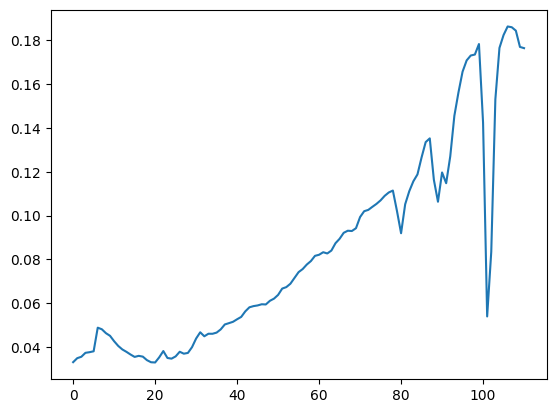

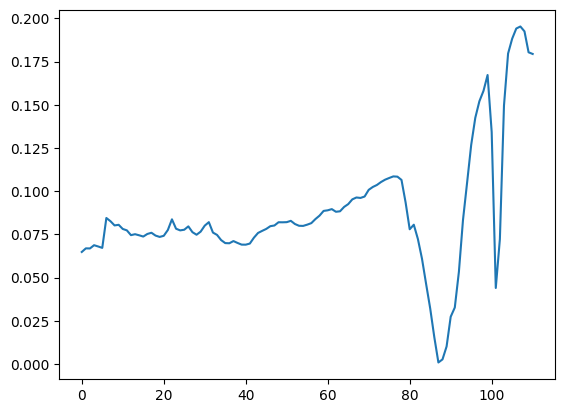

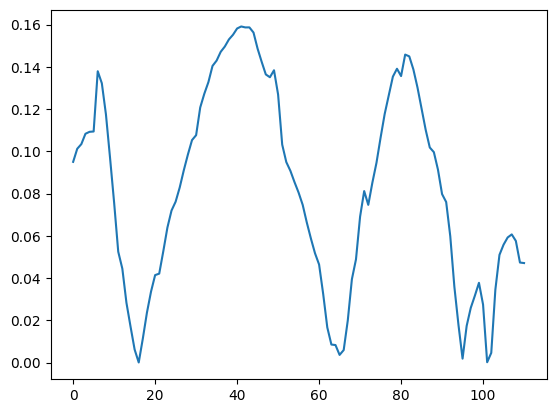

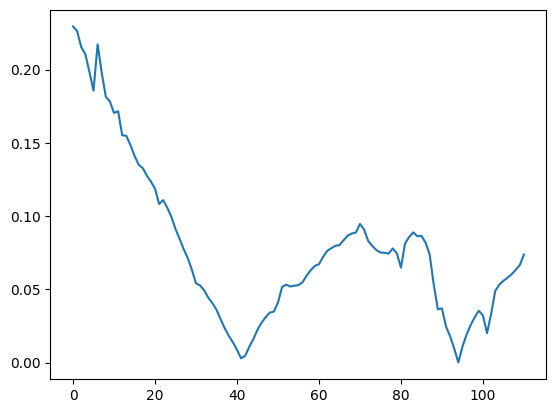

In [126]:
# Cameron has code on this, look at PCAfeatureSelection

pca = PCA()
# pca_components = pca.fit_transform(hsi[:,600:,:].reshape(-1, hsi.shape[2])).reshape(hsi.shape[0], -1, 120) # analyze l1a raw data
# pca_components = pca.fit_transform(l1b_cube[:,600:,6:-3].reshape(-1, 111)).reshape(hsi.shape[0], -1, 111) # analyze l1b radiance data
pca_components = pca.fit_transform(toa_rrs_cube[:,600:,6:-3].reshape(-1, 111)).reshape(hsi.shape[0], -1, 111) # analyze l1b reflectance data

# get loadings
contribution = np.abs(pca.components_)

# plot loadings for three first PCs
plt.plot(contribution[0,:])
plt.figure()
plt.plot(contribution[1,:])
plt.figure()
plt.plot(contribution[2,:])
plt.figure()
plt.plot(contribution[3,:])

### Sort pixels based on label

In [127]:
pca_components_sea   = []
pca_components_land  = []
pca_components_cloud = []

for i in range(florida_labled.shape[0]): 
    for j in range(0,florida_labled.shape[1] - 600,1): 
        if florida_labled[i,600 + j] == 0: 
            pca_components_sea.append(pca_components[i,j,:])
        if florida_labled[i,600 + j] == 1: 
            pca_components_land.append(pca_components[i,j,:])
        if florida_labled[i,600 + j] == 2: 
            pca_components_cloud.append(pca_components[i,j,:])



### Compute the difference in PCs between classes

<StemContainer object of 3 artists>

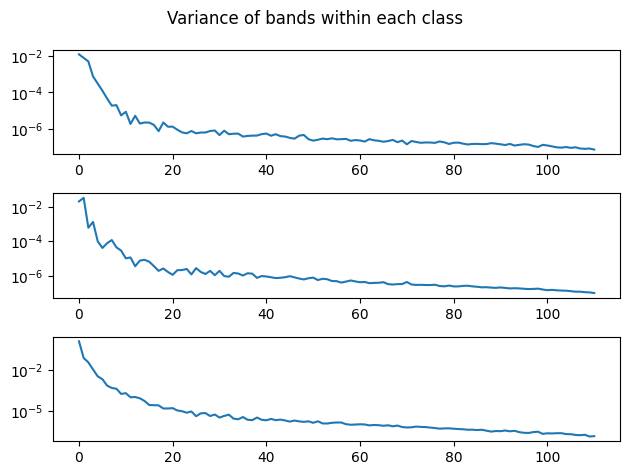

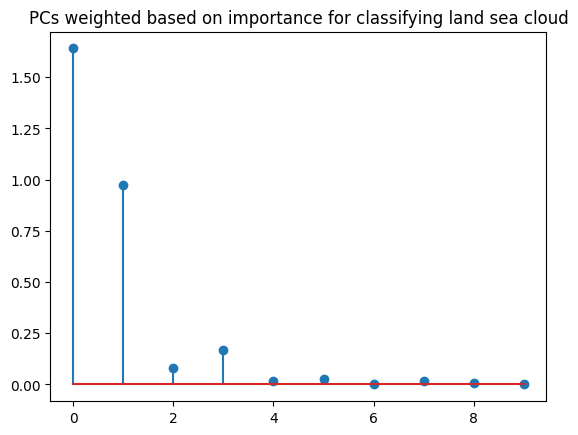

In [128]:
# get mean, corresponting to how much each PC typically is used to descripe each class, uses median instead of mean to be more robust to noise
pca_components_sea_mean =   np.median(np.array(pca_components_sea),   axis=0)
pca_components_land_mean =  np.median(np.array(pca_components_land),  axis=0)
pca_components_cloud_mean = np.median(np.array(pca_components_cloud), axis=0)

# compute the difference in PCs between each class
diff_1 = np.abs(pca_components_sea_mean - pca_components_land_mean)
diff_2 = np.abs(pca_components_sea_mean - pca_components_cloud_mean)
diff_3 = np.abs(pca_components_land_mean - pca_components_cloud_mean)
tot_diff = diff_1 + diff_2 + diff_3 # sum differences linearly

# Here we see that the variance within a class mostly lies in the first bands, this should maybe be incorporated into the decision..
plt.figure()
plt.suptitle('Variance of bands within each class')
plt.subplot(3,1,1)
plt.plot(np.var(np.array(pca_components_sea), axis=0))
plt.yscale('log')
plt.subplot(3,1,2)
plt.plot(np.var(np.array(pca_components_land), axis=0))
plt.yscale('log')
plt.subplot(3,1,3)
plt.plot(np.var(np.array(pca_components_cloud), axis=0))
plt.yscale('log')
plt.tight_layout()

plt.figure()
plt.title('PCs weighted based on importance for classifying land sea cloud')
plt.stem(tot_diff[:10])

### Find which PCs that are explain the most of the difference between classes (should rather make it variance between classes?)

[  1   0   3   2   7   6   5  12  13   9   8  18  11   4  19  10  14  15
  17  21  35  16  25  37  24  42  41  60  30  40  56  22  26  23  27  59
  46  51  47  31  32  73  48  28  81  53  64  44  29  58  20  68  55  52
  90  34  63  82  65  74  78  70 110  71  54  87  79  75  45 105 108  43
  76  67  38  69 104  66  93  85  95 102 107  97  96 109  61 103  94  98
  77 106 101  92  50  91  80  39  62  86  36  89  33 100  88  72  49  84
  99  57  83]
95.0 % of variance can be explained with 4 components


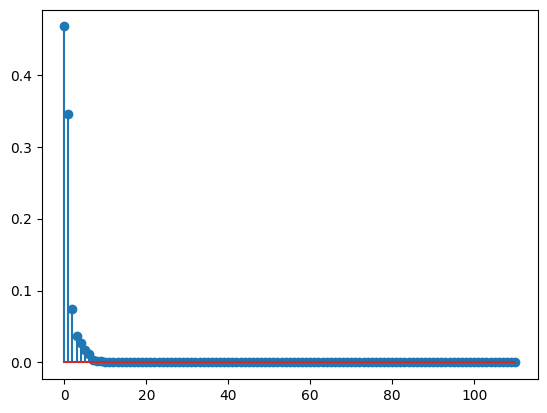

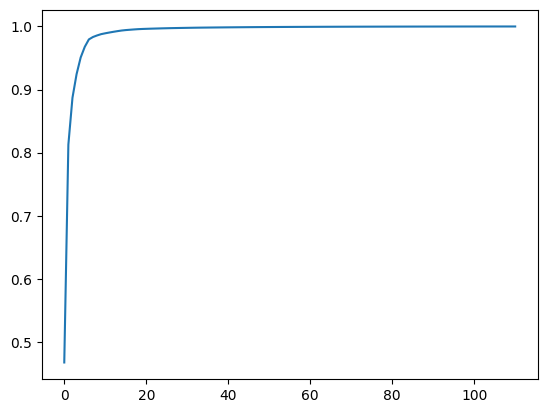

In [129]:
# just using all PCs

pca_components_median =   np.abs(np.median(pca_components.reshape(-1, pca_components.shape[2]),   axis=0))

pca_components_temp = pca_components_median.copy()
explained_variance = []
explained_variance_ordered = np.zeros_like(pca_components_median)
sum_explained_variance = []
indecies = []
total_vaiance = np.sum(pca_components_median)
var_threshold = 0.95
idx_threshold = 0
for i in range(len(pca_components_median)):
    explained_variance_ordered[i] = pca_components_median[i] / total_vaiance

    idx = np.argmax(pca_components_temp)
    indecies.append(idx)
    explained_variance.append(pca_components_temp[idx] / total_vaiance)
    sum_explained_variance.append(np.sum(explained_variance))
    pca_components_temp[idx] = -1 
    if idx_threshold == 0 and sum_explained_variance[-1] > var_threshold:
        idx_threshold = i
indecies = np.array(indecies)
print(indecies)
print(var_threshold*100, '% of variance can be explained with', idx_threshold, 'components')

plt.figure()
plt.stem(explained_variance[:])
plt.figure()
plt.plot(sum_explained_variance[:])

In [130]:
# using difference between sea land cloud PCs

'''tot_diff_temp = tot_diff.copy()
explained_variance = []
explained_variance_ordered = np.zeros_like(tot_diff)
sum_explained_variance = []
indecies = []
total_vaiance = np.sum(tot_diff)
var_threshold = 0.95
idx_threshold = 0
for i in range(len(tot_diff)):
    explained_variance_ordered[i] = tot_diff[i] / total_vaiance

    idx = np.argmax(tot_diff_temp)
    indecies.append(idx)
    explained_variance.append(tot_diff_temp[idx] / total_vaiance)
    sum_explained_variance.append(np.sum(explained_variance))
    tot_diff_temp[idx] = -1 
    if idx_threshold == 0 and sum_explained_variance[-1] > var_threshold:
        idx_threshold = i
indecies = np.array(indecies)
print(indecies)
print(var_threshold*100, '% of variance can be explained with', idx_threshold, 'components')

plt.figure()
plt.stem(explained_variance[:10])
plt.figure()
plt.plot(sum_explained_variance[:10])'''

"tot_diff_temp = tot_diff.copy()\nexplained_variance = []\nexplained_variance_ordered = np.zeros_like(tot_diff)\nsum_explained_variance = []\nindecies = []\ntotal_vaiance = np.sum(tot_diff)\nvar_threshold = 0.95\nidx_threshold = 0\nfor i in range(len(tot_diff)):\n    explained_variance_ordered[i] = tot_diff[i] / total_vaiance\n\n    idx = np.argmax(tot_diff_temp)\n    indecies.append(idx)\n    explained_variance.append(tot_diff_temp[idx] / total_vaiance)\n    sum_explained_variance.append(np.sum(explained_variance))\n    tot_diff_temp[idx] = -1 \n    if idx_threshold == 0 and sum_explained_variance[-1] > var_threshold:\n        idx_threshold = i\nindecies = np.array(indecies)\nprint(indecies)\nprint(var_threshold*100, '% of variance can be explained with', idx_threshold, 'components')\n\nplt.figure()\nplt.stem(explained_variance[:10])\nplt.figure()\nplt.plot(sum_explained_variance[:10])"

### Normalize loadings 

In [131]:
contribution_normalized = np.zeros_like(contribution)
for i in range(contribution.shape[0]):
    contribution_normalized[i,:] = contribution[i,:] / contribution[i,:].sum() 

print(contribution_normalized[:,:].sum(axis=1))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Weight loadings based on this importance of each PC

In [132]:
'''# iterate for each PC, weight each contribution by how important that PC is
weighted_wavelengths = np.zeros_like(contribution_normalized)
for i in range(explained_variance_ordered.shape[0]):
    weighted_wavelengths[i,:] = contribution_normalized[i,:] * explained_variance_ordered[i]'''

'# iterate for each PC, weight each contribution by how important that PC is\nweighted_wavelengths = np.zeros_like(contribution_normalized)\nfor i in range(explained_variance_ordered.shape[0]):\n    weighted_wavelengths[i,:] = contribution_normalized[i,:] * explained_variance_ordered[i]'

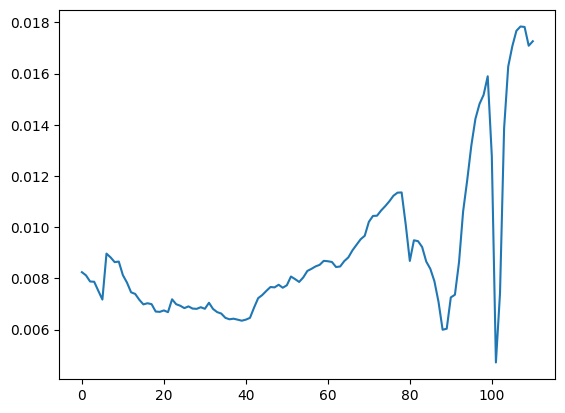

In [133]:
# make vector of weighted wavelengs, where values corresponts to how important each wavelenght is based on 
# how much they are used in each PC and how important that PC is
weighted_wavelengths = explained_variance_ordered @ contribution_normalized

plt.plot(weighted_wavelengths)

### Compute which wavelengths are most important based on weighted loadings

[113 114 112 116 115 111 110 105 104 103 102 109 101 106 100  84  83  82
  81  80  79  99  78  77  76  85  75  74  87  88  73  89  72  12  13  71
  65  86  70  66  90  15  67  14  98  64  63  69  68  91  62  61   6  16
   7  57  60  58  92   8   9  59  17  54  56  52  53  55  10  51  18 108
  19  97  50  96  49  28  11  20  93  37  22  23  29  21  30  32  35  48
  31  33  36  34  38  26  24  25  39  27  40  41  47  43  42  46  44  45
  95  94 107]
95.0 % of variance can be explained with 102 components


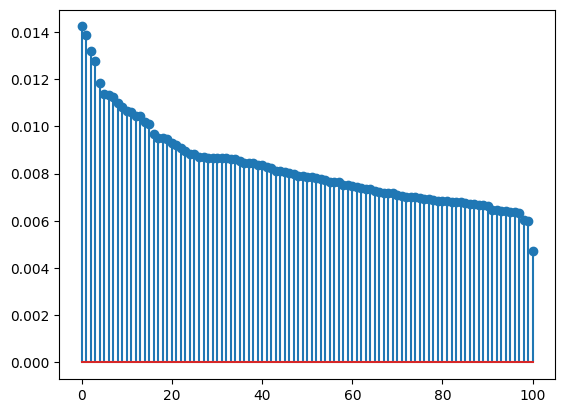

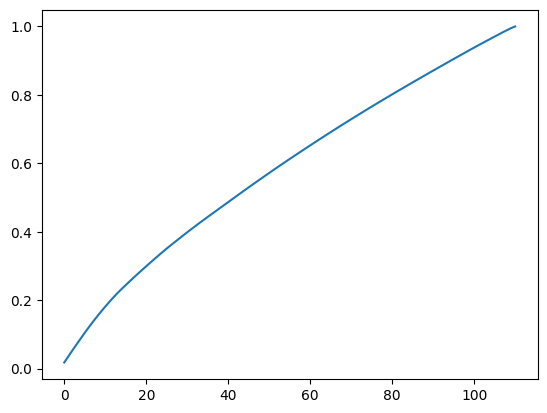

In [141]:
# sum_weighted_wavelengths = np.sum(weighted_wavelengths, axis=)

weighted_wavelengths_temp = weighted_wavelengths.copy()
explained_variance = []
sum_explained_variance = []
indecies = []
total_vaiance = np.sum(weighted_wavelengths)
var_threshold = 0.95
idx_threshold = 0
for i in range(len(weighted_wavelengths)):
    idx = np.argmax(weighted_wavelengths_temp)
    indecies.append(idx)
    explained_variance.append(weighted_wavelengths_temp[idx] / total_vaiance)
    sum_explained_variance.append(np.sum(explained_variance))
    weighted_wavelengths_temp[idx] = -1 #np.delete(weighted_wavelengths_temp, idx)
    if idx_threshold == 0 and sum_explained_variance[-1] > var_threshold:
        idx_threshold = i
explained_variance = np.array(explained_variance)
indecies = np.array(indecies)
print(indecies[:] +6)
print(var_threshold*100, '% of variance can be explained with', idx_threshold, 'components')

plt.figure()
plt.stem(explained_variance[10:])
plt.figure()
plt.plot(sum_explained_variance[:])

### Plot wavelengths in a singel point with least significant wavelengths removed

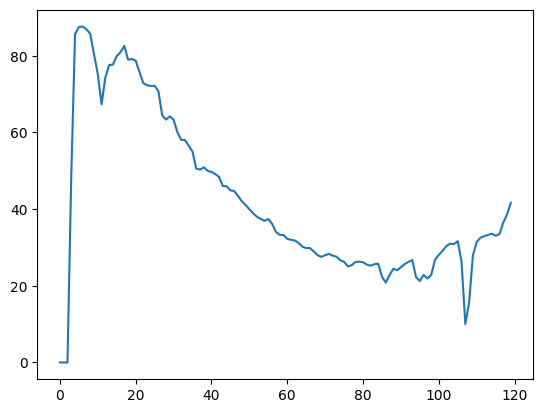

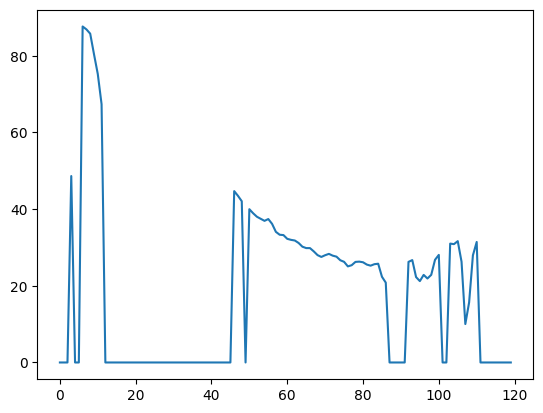

In [135]:
plt.plot(l1b_cube[0,0,:])
hsi_reduced = np.zeros_like(l1b_cube[0,0,:])
hsi_reduced[indecies[:idx_threshold]] = l1b_cube[0,0, indecies[:idx_threshold]]
plt.figure()
plt.plot(hsi_reduced)